In [79]:
import numpy as np
import random
from typing import List, Tuple, Dict

In [11]:

class BlackjackEnv:
    """
    Blackjack Environment Implementation
    
    This is a standard Blackjack game where player and dealer each start with 2 cards. 
    The goal is to get a sum as close to 21 as possible without exceeding it. Face cards 
    (J, Q, K) count as 10, and Ace can count as 1 or 11 (whichever is better). The player 
    acts first and can hit (take card) or stick (stop). The dealer follows a fixed strategy 
    of hitting on sum < 17 and sticking on sum >= 17. Cards are drawn from an infinite deck 
    with replacement. The state consists of player's current sum (12-21), dealer's visible 
    card (1-10), and whether the player has a usable ace. Actions are 0 (stick) or 1 (hit). 
    Rewards are +1 for win, -1 for loss, and 0 for draw.
    """
    
    # Constants
    BUST_THRESHOLD = 21
    ACE_HIGH = 11
    ACE_LOW = 1
    DEALER_THRESHOLD = 17
    FACE_VALUE = 10
    
    # Actions
    STICK = 0
    HIT = 1
    
    # Rewards
    WIN = 1
    LOSE = -1
    DRAW = 0
    CONTINUE = 0
    
    def __init__(self):
        self.reset()
    
    def reset(self) -> Tuple[int, int, bool]:
        """Reset environment and return initial state"""
        # Deal 2 cards to player and dealer
        self.player_cards = [self._draw_card(), self._draw_card()]
        self.dealer_cards = [self._draw_card(), self._draw_card()]
        
        self.player_sum, self.usable_ace = self._get_hand_value(self.player_cards)
        self.dealer_showing = self.dealer_cards[0]
        
        return (self.player_sum, self.dealer_showing, self.usable_ace)
    
    def step(self, action: int) -> Tuple[Tuple[int, int, bool], float, bool]:
        """
        Take action and return (next_state, reward, done)
        
        Args:
            action: ACTION_STICK or ACTION_HIT
            
        Returns:
            (state, reward, done)
        """
        if action == self.HIT:
            self.player_cards.append(self._draw_card())
            self.player_sum, self.usable_ace = self._get_hand_value(self.player_cards)
            
            if self.player_sum > self.BUST_THRESHOLD:  # Bust
                return (self.player_sum, self.dealer_showing, self.usable_ace), self.LOSE, True
            else:
                return (self.player_sum, self.dealer_showing, self.usable_ace), self.CONTINUE, False
        
        elif action == self.STICK:
            reward = self._dealer_play()
            return (self.player_sum, self.dealer_showing, self.usable_ace), reward, True
    
    def _draw_card(self) -> int:
        """
        Draw card from infinite deck with replacement
        
        Returns card value where:
        - Ace (1) = 1
        - Number cards (2-9) = face value  
        - Ten (10) = 10
        - Jack (11) = 10
        - Queen (12) = 10
        - King (13) = 10
        """
        return min(self.FACE_VALUE, random.randint(1, 13))
    
    def _get_hand_value(self, cards: list) -> Tuple[int, bool]:
        """Calculate hand value and determine if ace is usable"""
        total = sum(cards)
        aces = cards.count(self.ACE_LOW)
        usable_ace = False
        
        # Use ace as 11 if beneficial and doesn't cause bust
        if aces > 0 and total + (self.ACE_HIGH - self.ACE_LOW) <= self.BUST_THRESHOLD:
            total += (self.ACE_HIGH - self.ACE_LOW)
            usable_ace = True
        
        return total, usable_ace
    
    def _dealer_play(self) -> float:
        """Dealer plays according to fixed strategy and return reward"""
        dealer_sum, _ = self._get_hand_value(self.dealer_cards)
        
        # Dealer hits on < 17, sticks on >= 17
        while dealer_sum < self.DEALER_THRESHOLD:
            self.dealer_cards.append(self._draw_card())
            dealer_sum, _ = self._get_hand_value(self.dealer_cards)
        
        # Determine winner
        if dealer_sum > self.BUST_THRESHOLD:  # Dealer busts
            return self.WIN
        elif self.player_sum > dealer_sum:
            return self.WIN
        elif self.player_sum < dealer_sum:
            return self.LOSE
        else:
            return self.DRAW

In [19]:
env = BlackjackEnv()

policy = np.ones(22, dtype=int) # default: hit (1)
policy[20] = policy[21] = env.STICK # Stick (0) for sums 20 and 21

In [30]:
def simulate_episode(env, policy: np.ndarray) -> Tuple[List[Tuple[int, int, bool]], List[int]]:
    """
    Simulate one episode using given policy
    
    Args:
        env: BlackjackEnv instance
        policy: Policy array with shape (10,) indexed by player_sum
        
    Returns:
        tuple: (states, rewards) where:
            - states: List of (player_sum, dealer_card, usable_ace) tuples
            - rewards: List of rewards for each state-action pair
    """

    # Reset environment
    state = env.reset()
    done = False
    
    states = [state]
    rewards = []
    

    while not done:
        # Get action from policy
        player_sum, dealer_card, usable_ace = state
        
        # Get action from policy
        action = policy[player_sum]
        
        # Take action
        state, reward, done = env.step(action)
        rewards.append(reward)
        states.append(state)
    


    return states, rewards

In [31]:

# Example usage
if __name__ == "__main__":
    # Import the BlackjackEnv (assuming it's available)
    # from blackjack_env import BlackjackEnv
    
    print("Policy array:", policy)
    print("Policy interpretation:")
    print("Player sum | Action")
    print("-" * 18)
    for i, action in enumerate(policy):
        player_sum = i + 12
        action_name = "stick" if action == 0 else "hit"
        print(f"    {player_sum:2d}     | {action_name}")
    
    print("\n" + "="*30)

Policy array: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Policy interpretation:
Player sum | Action
------------------
    12     | hit
    13     | hit
    14     | hit
    15     | hit
    16     | hit
    17     | hit
    18     | hit
    19     | hit
    20     | hit
    21     | hit
    22     | hit
    23     | hit
    24     | hit
    25     | hit
    26     | hit
    27     | hit
    28     | hit
    29     | hit
    30     | hit
    31     | hit
    32     | stick
    33     | stick



In [39]:
print("Simulating 3 episodes:")
for i in range(3):
    states, rewards = simulate_episode(env, policy)
    total_return = sum(rewards)
    
    print(f"\nEpisode {i+1}:")
    print(f"States: {states}")
    print(f"Rewards: {rewards}")
    print(f"Total return: {total_return}")

Simulating 3 episodes:

Episode 1:
States: [(19, 7, False), (22, 7, False)]
Rewards: [-1]
Total return: -1

Episode 2:
States: [(13, 7, False), (16, 7, False), (18, 7, False), (19, 7, False), (29, 7, False)]
Rewards: [0, 0, 0, -1]
Total return: -1

Episode 3:
States: [(4, 2, False), (14, 2, False), (24, 2, False)]
Rewards: [0, -1]
Total return: -1


In [80]:
def policy_evaluation(env, policy: np.ndarray, max_iterations: int = 10000, 
                     check_iters: List[int] = None) -> Dict[int, np.ndarray]:
    """
    Evaluate a given policy using Monte Carlo first-visit method and track values at specified iterations.

    Args:
        env: An instance of BlackjackEnv.
        policy: A 1D numpy array of shape (22,) where policy[s] is the action 
                (0=stick, 1=hit) to take when player sum is s.
        max_iterations: Maximum number of episodes to simulate (default: 10000).
        check_iters: List of iterations to save value function snapshots (default: None).

    Returns:
        Dict[int, np.ndarray]: Dictionary mapping iteration numbers to value functions,
                              including all requested check points and final iteration.
    """
    # Initialize value function V(s) for all states
    V = np.zeros((22, 11, 2))  # [player_sum, dealer_card, usable_ace]
    
    # Initialize storage for value functions at check points
    value_snapshots = {}
    check_iters = sorted(check_iters) if check_iters else []
    
    # Returns(s) - store all returns for each state
    Returns = {}
    
    for iteration in range(max_iterations):
        # Generate an episode using current policy
        states, rewards = simulate_episode(env, policy)
        
        # Calculate returns for each state in the episode
        G = 0  # Return
        
        # Process states in reverse order
        for t in range(len(states) - 1, -1, -1):
            state = states[t]
            if t < len(rewards):
                G += rewards[t]
            
            if True:  # because each state is unique in episode
                player_sum, dealer_card, usable_ace = state
                
                if player_sum > env.BUST_THRESHOLD:
                    continue

                # Initialize Returns(s) if not exists
                if state not in Returns:
                    Returns[state] = []
                
                # Append G to Returns(s)
                Returns[state].append(G)
                
                # Update V(s) to average of Returns(s)
                V[player_sum, dealer_card, int(usable_ace)] = np.mean(Returns[state])
        
        # Save snapshot if this iteration is in check_iters
        if (iteration + 1) in check_iters:
            value_snapshots[iteration + 1] = V.copy()
    
    # Always include final iteration if not already included
    if max_iterations not in value_snapshots:
        value_snapshots[max_iterations] = V.copy()
    
    return value_snapshots

In [82]:
# Example usage:
check_points = [1000]
value_snapshots = policy_evaluation(env, policy, max_iterations=10000, check_iters=check_points)

# Plot value function for each snapshot
for iter_num, V in value_snapshots.items():
    print(f"Values at iteration {iter_num}:")
    # plot_blackjack_values_wireframe(V)

Values at iteration 1000:
Values at iteration 10000:


In [83]:
value_snapshots.keys()

dict_keys([1000, 10000])

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [125]:
def plot_blackjack_values_wireframe(value_snapshots: Dict[int, np.ndarray]):
    """
    Plot the state-value function for Blackjack as 3D wireframe plots.
    Layout:
    [After X episodes]                [After Y episodes]
    Usable ace
    [Plot1]                          [Plot2]
    No usable ace
    [Plot3]                          [Plot4]
    """
    if len(value_snapshots) != 2:
        raise ValueError("Function requires exactly 2 iterations to plot")
    
    # Get iterations and sort them
    iterations = sorted(value_snapshots.keys())
    iter1, iter2 = iterations[0], iterations[1]
    
    # Create figure
    fig = plt.figure(figsize=(12, 9))
    
    # Adjust spacing to provide room for titles and text labels
    plt.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, top=0.9, right=0.9)
    
    # Extract relevant ranges
    player_sums = np.arange(12, 22)  # 12-21
    dealer_cards = np.arange(1, 11)   # 1-10
    X, Y = np.meshgrid(dealer_cards, player_sums)
    
    # Plot settings
    plot_settings = {
        'color': 'black',
        'alpha': 0.8,
        'rstride': 1,
        'cstride': 1
    }

    # Add row titles on the left
    fig.text(0.02, 0.7, 'Usable\nace', ha='left', va='center', fontsize=12)
    fig.text(0.02, 0.3, 'No\nusable\nace', ha='left', va='center', fontsize=12)
    
    # Plot 1: Usable Ace, First Iteration (top left)
    ax1 = fig.add_subplot(221, projection='3d')
    Z1 = value_snapshots[iter1][12:22, 1:11, 1]
    ax1.plot_wireframe(X, Y, Z1, **plot_settings)
    ax1.set_xlabel('Dealer showing')
    ax1.set_ylabel('Player sum')
    ax1.set_zlabel('Value')
    ax1.view_init(elev=50, azim=-45)
    ax1.set_zlim(-1, 1)
    
    # Add title for first column - positioned above top-left subplot
    ax1.set_title(f'After {iter1:,} episodes', fontsize=14, pad=20)
    
    # Plot 2: Usable Ace, Second Iteration (top right)
    ax2 = fig.add_subplot(222, projection='3d')
    Z2 = value_snapshots[iter2][12:22, 1:11, 1]
    ax2.plot_wireframe(X, Y, Z2, **plot_settings)
    ax2.view_init(elev=50, azim=-45)
    ax2.set_zlim(-1, 1)
    
    # Add title for second column - positioned above top-right subplot
    ax2.set_title(f'After {iter2:,} episodes', fontsize=14, pad=20)
    
    # Plot 3: No Usable Ace, First Iteration (bottom left)
    ax3 = fig.add_subplot(223, projection='3d')
    Z3 = value_snapshots[iter1][12:22, 1:11, 0]
    ax3.plot_wireframe(X, Y, Z3, **plot_settings)
    ax3.view_init(elev=50, azim=-45)
    ax3.set_zlim(-1, 1)
    
    # Plot 4: No Usable Ace, Second Iteration (bottom right)
    ax4 = fig.add_subplot(224, projection='3d')
    Z4 = value_snapshots[iter2][12:22, 1:11, 0]
    ax4.plot_wireframe(X, Y, Z4, **plot_settings)
    ax4.view_init(elev=50, azim=-45)
    ax4.set_zlim(-1, 1)
    
    plt.show()

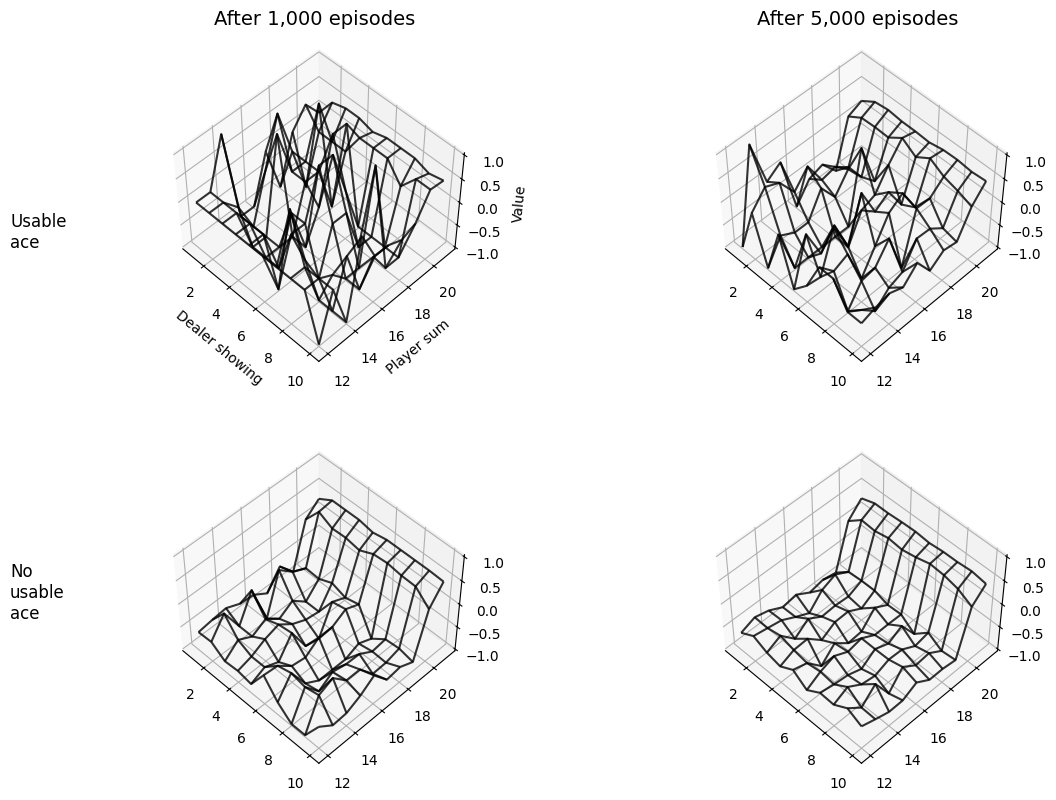

In [126]:

# Example usage:
check_points = [1000]
value_snapshots = policy_evaluation(env, policy, max_iterations=5000, check_iters=check_points)
plot_blackjack_values_wireframe(value_snapshots)